# Megaline - ¿Cuál es la mejor tarifa?

La empresa Megaline ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Realizaremos un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña.  
Contamos con los datos de 500 clientes de Megaline:
* Quiénes son los clientes
* De dónde son
* Qué tarifa usan
* Cantidad de llamadas que hicieron
* Mensajes de texto que enviaron en 2018  

Nuestro trabajo será analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

Este proyecto tiene como objetivo estudiar el comportamiento de los usuarios de una red telefónica para determinar cómo influye el plan al que están suscritos en su consumo y en los ingresos de la empresa.

## Inicialización

In [1]:
# Cargamos las librerías necesarias
import pandas as pd
import numpy as np
import math as mt
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st

## Cargar datos

In [2]:
# Cargamos los archivos de datos en diferentes DataFrames
df_calls = pd.read_csv('./datasets/megaline_calls.csv')
df_internet = pd.read_csv('./datasets/megaline_internet.csv')
df_messages = pd.read_csv('./datasets/megaline_messages.csv')
df_plans = pd.read_csv('./datasets/megaline_plans.csv')
df_users = pd.read_csv('./datasets/megaline_users.csv')

## Preparar los datos

## Tarifas

In [3]:
# Imprimimos la información general sobre el DataFrame de las tarifas
df_plans.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [4]:
# Imprimimos una muestra de los datos para las tarifas
df_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Los datos sobre los planes, no contienen valores nulos. Los tipos de datos son correctos, aunque tal vez, se podría cambiar el tipo de dato a float para todas las columnas que hagan referencia a un precio. Sin embargo, no es realmente necesario, ya que los valores que almacenan esas columnas son todos enteros, al igual que no necesitan ser de tipo float para hacer operaciones con ellos.

### Corregir datos

No hay problema con los datos de las tarifas.

### Enriquecer los datos

Es importante destacar que los datos incluidos en el plan, están en megabytes, sin embargo el precio especificado es por cada gigabyte, por lo que habrá que hacer una conversión.

In [5]:
# realizamos la conversión de los datos incluidos en cada plan, dividientdo los megabytes entre 1024
df_plans['mb_per_month_included'] = df_plans['mb_per_month_included'].div(1024)
df_plans.rename(columns={'mb_per_month_included': 'gb_per_month_included'}, inplace=True) # cambiamos el nombre de la columna
df_plans

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


## Usuarios/as

In [6]:
# Imprimimos la información general sobre el DataFrame de usuarios
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
# Imprimimos una muestra de datos para usuarios
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


Tenemos dos campos que contienen datos de fechas, la fecha de suscripción y la fecha en la que el usuario dejo de usar el servicio. Podemos cambiar el tipo de dato a datetime para poder extraer datos específicos, como el día o el año, con más facilidad.  
Además, podemos observar que la mayoría de los usarios no tienen una fecha de abandono (churn_date).

### Corregir los datos

Cambiamos el tipo de dato para las columnas reg_date y churn_date.

In [8]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')

df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


## Llamadas

In [9]:
# Imprimimos la información general sobre el DataFrame de las llamadas

df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [10]:
# Imprimimos una muestra de datos para las llamadas

df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


Podemos cambiar el tipo de dato para las fechas de las llamadas (call_date) a datetime.

In [11]:
# Buscamos anomalías dentro de la duración de las llamadas
df_calls[df_calls.duration==0]

,id,user_id,call_date,duration
19,1001_4,1001,2018-12-05,0.0
25,1001_13,1001,2018-12-24,0.0
31,1001_30,1001,2018-10-17,0.0
32,1001_31,1001,2018-11-03,0.0
34,1001_35,1001,2018-12-21,0.0
...,...,...,...,...
137714,1499_183,1499,2018-11-10,0.0
137715,1499_184,1499,2018-09-15,0.0
137720,1499_189,1499,2018-12-27,0.0
137722,1499_191,1499,2018-12-24,0.0


Podemos eliminar las llamadas que tengan una duración igual a cero. Estas llamadas no deberían cobrarse al usuario, ya que posiblemente se traten de errores en el sistema o llamadas que no fueron contestadas.

### Corregir los datos

Cambiamos el tipo de dato de 'call_date', de 'object' a 'datetime'

In [12]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


Eliminamos las llamadas con una duración igual a cero.

In [13]:
df_calls = df_calls[df_calls['duration']!=0]
df_calls[df_calls['duration']==0]

,id,user_id,call_date,duration


### Enriquecer los datos

Agregamos una columna que nos indique el número del mes de la llamada, lo cual nos será de utilidad más adelante.

In [14]:
df_calls['month'] = df_calls['call_date'].dt.month
print(df_calls)

              id  user_id  call_date  duration  month
0        1000_93     1000 2018-12-27      8.52     12
1       1000_145     1000 2018-12-27     13.66     12
2       1000_247     1000 2018-12-27     14.48     12
3       1000_309     1000 2018-12-28      5.76     12
4       1000_380     1000 2018-12-30      4.22     12
...          ...      ...        ...       ...    ...
137730  1499_199     1499 2018-11-21      8.72     11
137731  1499_200     1499 2018-10-20     10.89     10
137732  1499_201     1499 2018-09-21      8.12      9
137733  1499_202     1499 2018-10-10      0.37     10
137734  1499_203     1499 2018-12-29     13.86     12

[110901 rows x 5 columns]


## Mensajes

In [15]:
# Imprimimos la información general sobre el DataFrame de los mensajes

df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [16]:
# Imprimimos una muestra de datos para los mensajes

df_messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


Puede ser útil cambiar el tipo de datos para las fechas a datatime.

### Corregir los datos

Cambiamos el tipo de dato para la fecha de los mensajes.

In [17]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


### Enriquecer los datos

Agregamos una columna que indica el número del mes del mensaje.

In [18]:
df_messages['month'] = df_messages['message_date'].dt.month
print(df_messages)

             id  user_id message_date  month
0      1000_125     1000   2018-12-27     12
1      1000_160     1000   2018-12-31     12
2      1000_223     1000   2018-12-31     12
3      1000_251     1000   2018-12-27     12
4      1000_255     1000   2018-12-26     12
...         ...      ...          ...    ...
76046  1497_526     1497   2018-12-24     12
76047  1497_536     1497   2018-12-24     12
76048  1497_547     1497   2018-12-31     12
76049  1497_558     1497   2018-12-24     12
76050  1497_613     1497   2018-12-23     12

[76051 rows x 4 columns]


## Internet

In [19]:
# Imprimimos la información general sobre el DataFrame de internet

df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [20]:
# Imprimimos una muestra de datos para el tráfico de internet

df_internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Las fechas para la sesión son más accesibles cuando son de tipo datetime, así que cambiaremos el tipo de dato.

### Corregir los datos

Cambiamos el tipo de dato de las fechas de las sesiones.

In [21]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### Enriquecer los datos

Agregamos una columna para los meses de cada sesión.

In [22]:
df_internet['month'] = df_internet['session_date'].dt.month
print(df_internet)

              id  user_id session_date  mb_used  month
0        1000_13     1000   2018-12-29    89.86     12
1       1000_204     1000   2018-12-31     0.00     12
2       1000_379     1000   2018-12-28   660.40     12
3       1000_413     1000   2018-12-26   270.99     12
4       1000_442     1000   2018-12-27   880.22     12
...          ...      ...          ...      ...    ...
104820  1499_215     1499   2018-10-20   218.06     10
104821  1499_216     1499   2018-12-30   304.72     12
104822  1499_217     1499   2018-09-22   292.75      9
104823  1499_218     1499   2018-12-07     0.00     12
104824  1499_219     1499   2018-12-24   758.31     12

[104825 rows x 5 columns]


### Nota
Debido a que los megabytes utilizados se redondean a gigabytes, así como los segundos se redondean a minutos, necesitaremos hacer una conversión y posteriormente un redondeo, antes de hacer cualquier operación con datos de las sesiones o llamadas. Pero no podremos hacerlo hasta obtener el consumo total de cada usuario durante el mes.

## Estudiar las condiciones de las tarifas

Volvamos a revisar las condiciones de los planes

In [23]:
df_plans

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


El plan SURF incluye 50 mensajes, 15 gb, 500 minutos por $20 USD al mes. Al superar estos límites, se pagará:
* $0.03 USD por cada mensaje extra
* $10 USD por cada gb extra
* $0.03 USD por cada minuto extra

Por su parte, el plan ULTIMATE incluye 1000 mensajes, 30 gb, 3000 minutos por $70 USD al mes.
* $0.01 USD por cada mensaje extra
* $7 USD por cada gb extra
* $0.01 USD por cada minuto extra

## Agregar datos por usuario

Agruparemos los datos para obtener un resumen del consumo mensual de cada usuario.

In [24]:
# Obtenemos el número de llamadas hechas por cada usuario al mes.
df_calls_monthly=df_calls.groupby(['user_id','month'])['id'].count().reset_index()
print(df_calls_monthly)

      user_id  month  id
0        1000     12  16
1        1001      8  22
2        1001      9  38
3        1001     10  47
4        1001     11  49
...       ...    ...  ..
2251     1498     12  32
2252     1499      9  35
2253     1499     10  41
2254     1499     11  39
2255     1499     12  56

[2256 rows x 3 columns]


In [25]:
# Calculamos el número total de minutos y el número de llamadas hechas por cada usuario al mes.
#pivot_calls = df_calls.pivot_table(index=['user_id', 'month'],
#                                   values=['duration'],
#                                   aggfunc=['sum','count']).reset_index()
#pivot_calls

In [26]:
#pivot_calls['sum','duration'] = pivot_calls['sum','duration'].apply(mt.ceil) #redondemos el número de minutos hacia arriba 

In [27]:
# Obtenemos la cantidad de minutos usados por cada usuario al mes. 

df_duration_monthly=df_calls.groupby(['user_id','month'])['duration'].sum().reset_index()
df_duration_monthly['duration']= df_duration_monthly['duration'].apply(mt.ceil) #redondemos el número de minutos hacia arriba 
print(df_duration_monthly)

      user_id  month  duration
0        1000     12       117
1        1001      8       172
2        1001      9       298
3        1001     10       375
4        1001     11       405
...       ...    ...       ...
2251     1498     12       325
2252     1499      9       331
2253     1499     10       364
2254     1499     11       289
2255     1499     12       469

[2256 rows x 3 columns]


In [28]:
# Obtenemos el número de mensajes enviados por cada usuario al mes. 
df_messages_monthly=df_messages.groupby(['user_id','month'])['id'].count().reset_index()
print(df_messages_monthly)

      user_id  month  id
0        1000     12  11
1        1001      8  30
2        1001      9  44
3        1001     10  53
4        1001     11  36
...       ...    ...  ..
1801     1496      9  21
1802     1496     10  18
1803     1496     11  13
1804     1496     12  11
1805     1497     12  50

[1806 rows x 3 columns]


In [29]:
# Obtenemos el volumen del tráfico de Internet usado por cada usuario al mes. 

df_traffic_monthly = df_internet.groupby(['user_id','month'])['mb_used'].sum().reset_index()
print(df_traffic_monthly)

      user_id  month   mb_used
0        1000     12   1901.47
1        1001      8   6919.15
2        1001      9  13314.82
3        1001     10  22330.49
4        1001     11  18504.30
...       ...    ...       ...
2272     1498     12  23137.69
2273     1499      9  12984.76
2274     1499     10  19492.43
2275     1499     11  16813.83
2276     1499     12  22059.21

[2277 rows x 3 columns]


Ahora que tenemos el total de megabytes que el usuario consumió durante el mes, haremos la conversión a gigabytes y el redondeo hacia arriba.

In [30]:
df_traffic_monthly['mb_used'] = df_traffic_monthly['mb_used'].div(1024).apply(mt.ceil)
df_traffic_monthly.rename(columns={'mb_used': 'gb_used'}, inplace=True)
print(df_traffic_monthly)

      user_id  month  gb_used
0        1000     12        2
1        1001      8        7
2        1001      9       14
3        1001     10       22
4        1001     11       19
...       ...    ...      ...
2272     1498     12       23
2273     1499      9       13
2274     1499     10       20
2275     1499     11       17
2276     1499     12       22

[2277 rows x 3 columns]


Vamos a consolidar los datos de todos los DataFrames generados para obtener el consumo de llamadas, mensajes e internet de cada usuario en un solo DataFrame.

In [31]:
# Cruzamos la información en un solo dataframe por user_id y mes
df_user_consumption = df_calls_monthly.merge( # mezclamos las llamadas mensuales con los minutos por llamada
    df_duration_monthly,
    on=['user_id','month'],
    how='outer',
)

#df_user_consumption = pivot_calls.merge( # mezclamos llamadas mensuales y los minutos por llamada con los mensajes enviados
df_user_consumption = df_user_consumption.merge( # mezclamos el df resultante con los mensajes enviados
    df_messages_monthly,
    on=['user_id','month'],
    how='outer',
)

df_user_consumption = df_user_consumption.merge( # mezclamos el df resultante con el consumos de datos
    df_traffic_monthly,
    on=['user_id','month'],
    how='outer',
)

print(df_user_consumption.isna().sum())

print(df_user_consumption)


user_id       0
month         0
id_x         37
duration     37
id_y        487
gb_used      16
dtype: int64
      user_id  month  id_x  duration  id_y  gb_used
0        1000     12  16.0     117.0  11.0      2.0
1        1001      8  22.0     172.0  30.0      7.0
2        1001      9  38.0     298.0  44.0     14.0
3        1001     10  47.0     375.0  53.0     22.0
4        1001     11  49.0     405.0  36.0     19.0
...       ...    ...   ...       ...   ...      ...
2288     1498     12  32.0     325.0   NaN     23.0
2289     1499      9  35.0     331.0   NaN     13.0
2290     1499     10  41.0     364.0   NaN     20.0
2291     1499     11  39.0     289.0   NaN     17.0
2292     1499     12  56.0     469.0   NaN     22.0

[2293 rows x 6 columns]


In [32]:
# Obtenemos los nombres de los planes
df_user_consumption = df_users[['user_id','plan']].merge(
    df_user_consumption,
    on='user_id',
    how='right',
)

df_user_consumption.columns =['user_id','plan_name','month','calls','minutes','messages','gb'] # Renombramos las columnas

print(df_user_consumption.isna().sum())
print(df_user_consumption)

user_id        0
plan_name      0
month          0
calls         37
minutes       37
messages     487
gb            16
dtype: int64
      user_id plan_name  month  calls  minutes  messages    gb
0        1000  ultimate     12   16.0    117.0      11.0   2.0
1        1001      surf      8   22.0    172.0      30.0   7.0
2        1001      surf      9   38.0    298.0      44.0  14.0
3        1001      surf     10   47.0    375.0      53.0  22.0
4        1001      surf     11   49.0    405.0      36.0  19.0
...       ...       ...    ...    ...      ...       ...   ...
2288     1498      surf     12   32.0    325.0       NaN  23.0
2289     1499      surf      9   35.0    331.0       NaN  13.0
2290     1499      surf     10   41.0    364.0       NaN  20.0
2291     1499      surf     11   39.0    289.0       NaN  17.0
2292     1499      surf     12   56.0    469.0       NaN  22.0

[2293 rows x 7 columns]


In [33]:
df_user_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    2293 non-null   int64  
 1   plan_name  2293 non-null   object 
 2   month      2293 non-null   int32  
 3   calls      2256 non-null   float64
 4   minutes    2256 non-null   float64
 5   messages   1806 non-null   float64
 6   gb         2277 non-null   float64
dtypes: float64(4), int32(1), int64(1), object(1)
memory usage: 116.6+ KB


El procesos anterior se hizo de esta manera por lo siguiente.  
Supongamos que hemos cruzado del df que contiene el número de llamadas con los campos 'user_id' y 'plan' del df de usuarios, como resultado tenemos un df con las columnas 'user_id','plan','month' y 'calls'.  
Ahora, queremos cruzar el df anterior con el df que contiene el número de mensajes. Pero, si hay un mensaje el cuál no coincida en 'user_id' y 'month', ya que el usuario no hizo ninguna llamada ese mes, la información se perderá, por eso el parametro 'how' es 'outer', para que no se descarten datos.  
Sin embargo, hay algo más que debemos considerar, los datos que no coincidan, tendrán un valor ausente en el campo donde va el nombre del plan. Es por esto que los dataframes originales también deben tener este campo por defecto.

In [34]:
# Añade la información de la tarifa

df_user_consumption = df_user_consumption.merge( # agregamos la información de la tarifa según el plan de cada usuario
    df_plans,
    on='plan_name',
    how='left',
)

#df_user_consumption=df_user_consumption.drop('plan_name', axis='columns')
print(df_user_consumption)

      user_id plan_name  month  calls  minutes  messages    gb  \
0        1000  ultimate     12   16.0    117.0      11.0   2.0   
1        1001      surf      8   22.0    172.0      30.0   7.0   
2        1001      surf      9   38.0    298.0      44.0  14.0   
3        1001      surf     10   47.0    375.0      53.0  22.0   
4        1001      surf     11   49.0    405.0      36.0  19.0   
...       ...       ...    ...    ...      ...       ...   ...   
2288     1498      surf     12   32.0    325.0       NaN  23.0   
2289     1499      surf      9   35.0    331.0       NaN  13.0   
2290     1499      surf     10   41.0    364.0       NaN  20.0   
2291     1499      surf     11   39.0    289.0       NaN  17.0   
2292     1499      surf     12   56.0    469.0       NaN  22.0   

      messages_included  gb_per_month_included  minutes_included  \
0                  1000                   30.0              3000   
1                    50                   15.0               500   
2  

In [35]:
df_user_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                2293 non-null   int64  
 1   plan_name              2293 non-null   object 
 2   month                  2293 non-null   int32  
 3   calls                  2256 non-null   float64
 4   minutes                2256 non-null   float64
 5   messages               1806 non-null   float64
 6   gb                     2277 non-null   float64
 7   messages_included      2293 non-null   int64  
 8   gb_per_month_included  2293 non-null   float64
 9   minutes_included       2293 non-null   int64  
 10  usd_monthly_pay        2293 non-null   int64  
 11  usd_per_gb             2293 non-null   int64  
 12  usd_per_message        2293 non-null   float64
 13  usd_per_minute         2293 non-null   float64
dtypes: float64(7), int32(1), int64(5), object(1)
memory usag

Calculamos el pago mensual que debe hacer cada usario con respecto a los mensajes, llamadas y datos que consumió durante el mes.

In [36]:
# Calcula el ingreso mensual para cada usuario

# Esta función comprueba que no haya números negativos al restar los servicios incluidos a los servicios consumidos
def less_zero(x):
    if x<0:
        return 0
    else:
        return x
    
# Llenamos con ceros los valores ausentes en mensajes, minutos y mb para poder hacer cálculos
df_user_consumption[['gb','minutes','messages']] = df_user_consumption[['gb','minutes','messages']].fillna(0)

# minutos extras
df_user_consumption['monthly_rate'] = (df_user_consumption['minutes']-df_user_consumption['minutes_included'])*df_user_consumption['usd_per_minute']
df_user_consumption['monthly_rate'] = df_user_consumption['monthly_rate'].apply(less_zero) # si el usuario no consumió todos sus minutos 

# mensajes extras
df_user_consumption['monthly_rate'] += (df_user_consumption['messages']-df_user_consumption['messages_included'])*df_user_consumption['usd_per_message']
df_user_consumption['monthly_rate'] = df_user_consumption['monthly_rate'].apply(less_zero) # si el usuario no consumió todos sus mensajes

# gigabytes extras
df_user_consumption['monthly_rate'] += (df_user_consumption['gb']-df_user_consumption['gb_per_month_included'])* df_user_consumption['usd_per_gb']
df_user_consumption['monthly_rate'] = df_user_consumption['monthly_rate'].apply(less_zero) # si el usuario no consumió todos sus gb

#sumamos el precio mensual del plan 
df_user_consumption['monthly_rate']+=df_user_consumption['usd_monthly_pay']

print(df_user_consumption['monthly_rate'])

0        70.00
1        20.00
2        20.00
3        90.09
4        60.00
         ...  
2288    100.00
2289     20.00
2290     70.00
2291     40.00
2292     90.00
Name: monthly_rate, Length: 2293, dtype: float64


## Estudia el comportamiento de usuario

Estudiaremos el comportamiento de los usuarios en diferentes escenarios.

### Llamadas
Comparamos la duración mensual promedio de llamadas por cada plan.

In [ ]:
# Agrupamos los datos por mes y por plan y obtenemos la duración promedio
mean_minutes_per_plan = df_user_consumption.groupby(['month','plan_name'])['minutes'].mean().reset_index()
print(mean_minutes_per_plan)

    month plan_name     minutes
0       1      surf  193.000000
1       1  ultimate  183.750000
2       2      surf  281.333333
3       2  ultimate  380.428571
4       3      surf  311.434783
5       3  ultimate  286.166667
6       4      surf  332.920000
7       4  ultimate  317.095238
8       5      surf  377.532468
9       5  ultimate  384.206897
10      6      surf  407.690722
11      6  ultimate  350.340426
12      7      surf  424.991736
13      7  ultimate  404.271186
14      8      surf  387.660494
15      8  ultimate  397.788732
16      9      surf  391.453608
17      9  ultimate  413.779070
18     10      surf  406.202532
19     10  ultimate  425.688679
20     11      surf  400.063604
21     11  ultimate  420.944882
22     12      surf  447.981132
23     12  ultimate  433.549669


In [ ]:
# Transformamos los meses en indices y los 2 planes en columnas para poder gráficar adecuadamente
mean_minutes_per_plan = mean_minutes_per_plan.pivot_table(index='month', columns='plan_name', values='minutes')
print(mean_minutes_per_plan)

plan_name        surf    ultimate
month                            
1          193.000000  183.750000
2          281.333333  380.428571
3          311.434783  286.166667
4          332.920000  317.095238
5          377.532468  384.206897
6          407.690722  350.340426
7          424.991736  404.271186
8          387.660494  397.788732
9          391.453608  413.779070
10         406.202532  425.688679
11         400.063604  420.944882
12         447.981132  433.549669


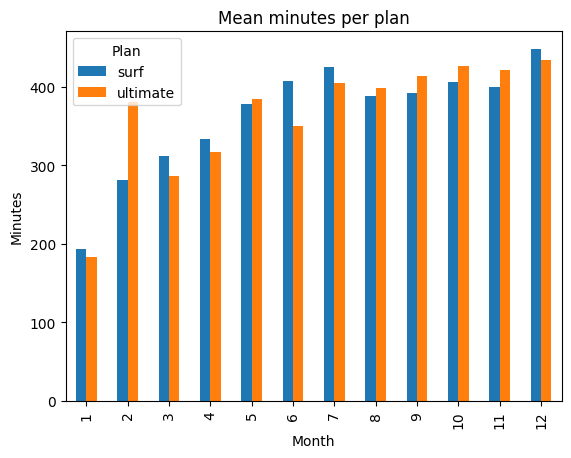

In [45]:
#months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

mean_minutes_per_plan.plot(
    kind='bar',
    title='Mean minutes per plan',
    xlabel='Month',
    ylabel='Minutes',
)
plt.legend(title='Plan')

#plt.xticks(range(len(months)), months)

Observamos que en febrero, los usuarios pasanron más tiempo en llamadas para el plan ultimate. El resto del año, la duración promedio de llamadas de ambos planes, siguen una distribución bastate similar. 

Ahora, comparemos el número total de minutos mensuales que necesitan los usuarios de cada plan.

In [ ]:
# Obtenemos el número total de minutos mensuales que consume cada usuario por mes en cada plan.
sum_minutes_per_user_id = df_user_consumption.groupby(['user_id','month','plan_name'])['minutes'].sum().reset_index()
print(sum_minutes_per_user_id)

      user_id  month plan_name  minutes
0        1000     12  ultimate    117.0
1        1001      8      surf    172.0
2        1001      9      surf    298.0
3        1001     10      surf    375.0
4        1001     11      surf    405.0
...       ...    ...       ...      ...
2288     1498     12      surf    325.0
2289     1499      9      surf    331.0
2290     1499     10      surf    364.0
2291     1499     11      surf    289.0
2292     1499     12      surf    469.0

[2293 rows x 4 columns]


In [48]:
# Separamos los usuarios por plan
ultimate = sum_minutes_per_user_id[sum_minutes_per_user_id['plan_name']=='ultimate']['minutes']
surf = sum_minutes_per_user_id[sum_minutes_per_user_id['plan_name']=='surf']['minutes']
print(ultimate)
print(surf)

0       117.0
19       10.0
20       55.0
26      451.0
27      423.0
        ...  
2258    506.0
2259    425.0
2260    473.0
2261    447.0
2277    277.0
Name: minutes, Length: 720, dtype: float64
1       172.0
2       298.0
3       375.0
4       405.0
5       393.0
        ...  
2288    325.0
2289    331.0
2290    364.0
2291    289.0
2292    469.0
Name: minutes, Length: 1573, dtype: float64


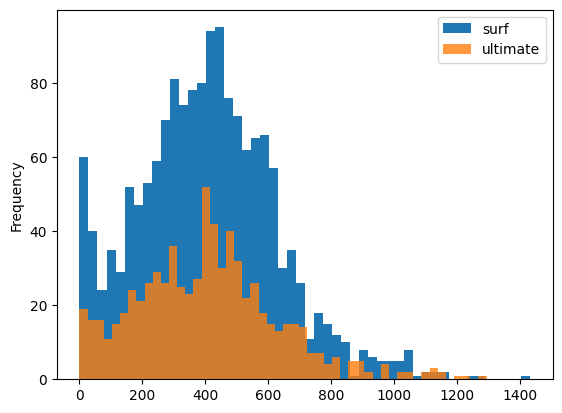

In [49]:
# Creamos un histograma con los dos segmentos para ver las diferencias
surf.plot(kind='hist',bins=50)
ultimate.plot(kind='hist',bins=50, alpha=0.8)
plt.legend(['surf', 'ultimate']) 

En general, las llamadas de los usuarios de ambos planes, suelen durar entre 200 y 600 minutos al mes.

In [ ]:
# Calculamos la media y la varianza de la duración mensual de llamadas para cada plan.

minutes_per_plan = df_user_consumption.groupby(['month','plan_name'])['minutes'].sum().reset_index()

minutes_plan_surf = minutes_per_plan[minutes_per_plan['plan_name']=='surf']['minutes']
minutes_plan_ultimate = minutes_per_plan[minutes_per_plan['plan_name']=='ultimate']['minutes']

print('Media para el plan SURF:',minutes_plan_surf.mean())
print('Media para el plan ULTIMATE:',minutes_plan_ultimate.mean())
print()
print('Varianza para el plan SURF:',np.var(minutes_plan_surf))
print('Varianza para el plan ULTIMATE:',np.var(minutes_plan_ultimate))

Media para el plan SURF: 53121.333333333336
Media para el plan ULTIMATE: 24402.333333333332

Varianza para el plan SURF: 1968123932.3888886
Varianza para el plan ULTIMATE: 427173695.72222227


In [51]:
minutes_per_plan

,month,plan_name,minutes
0,1,surf,386.0
1,1,ultimate,735.0
2,2,surf,2532.0
3,2,ultimate,2663.0
4,3,surf,7163.0
5,3,ultimate,3434.0
6,4,surf,16646.0
7,4,ultimate,6659.0
8,5,surf,29070.0
9,5,ultimate,11142.0


count        12.000000
mean      53121.333333
std       46336.209274
min         386.000000
25%       14275.250000
50%       45485.000000
75%       81024.000000
max      142458.000000
Name: minutes, dtype: float64


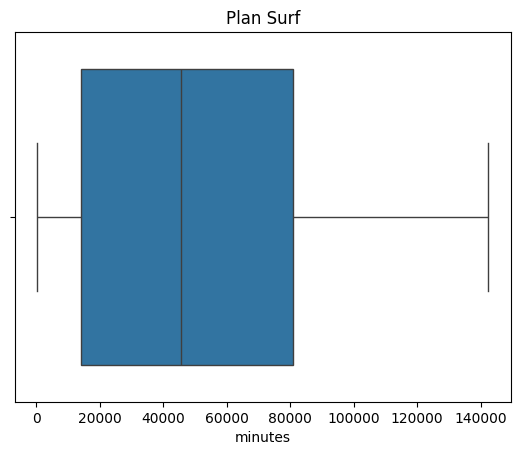

count       12.000000
mean     24402.333333
std      21587.210752
min        735.000000
25%       5852.750000
50%      20159.000000
75%      37969.500000
max      65466.000000
Name: minutes, dtype: float64


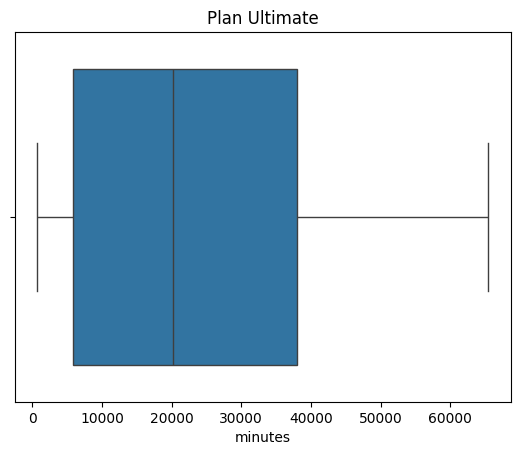

In [73]:
# Trazamos dos diagramas de caja para visualizar las distribuciones de la duración mensual de llamadas en ambos planes

print(minutes_plan_surf.describe())
surf_plt= sns.boxplot(x=minutes_plan_surf)
surf_plt.set_title('Plan Surf')
plt.show()

print(minutes_plan_ultimate.describe())
ultimate_plt=sns.boxplot(x=minutes_plan_ultimate)
ultimate_plt.set_title('Plan Ultimate')
plt.show()

Sabemos que por cada mes, los minutos para el plan Surf, van desde 386 hasta 142 mil. Es un rango muy amplio, sin embargo, gracias a que la mediana es una medida de posición estructural que no se ve afectada por los valores atípicos, sabemos que el 50% de los datos está por debajo de 45 mil minutos. Además, el 75% de los datos está por debajo de 81 mil minutos.

Para el plan Ultimate, tenemos que el valor minimo es 735 minutos y el máximo 65,466. El rango de valores es menor al plan Surf. así como el valor máximo, Más aún, gracias al diagrama de caja, sabemos que el 50% de los datos está por debajo de 20 mil minutos y el 75% está por debajo de 38 mil minutos.  

Tambien es importante señalar que el intervalo intercuartílico (Q3-Q1) que indica el 50% medio de los datos, para el plan Surf es apróximadamente de 66,700 minutos; mientras que para el el plan Ultimate es de apróximadamente 32 mil minutos.

Por todo lo anterior, podemos concluir que los usuarios del plan Surf pasan casi 50% más de tiempo en llamadas, por mes, que los usuarios del plan Ultimate.

### Mensajes
Comparemos los mensajes mensuales promedio por cada plan.

plan_name       surf   ultimate
month                          
1          10.500000  15.500000
2          12.000000  21.571429
3          15.260870  20.250000
4          17.400000  22.047619
5          24.012987  32.103448
6          25.298969  29.340426
7          27.033058  32.830508
8          28.777778  38.478873
9          30.762887  37.895349
10         33.839662  39.443396
11         32.385159  38.606299
12         38.600629  45.006623


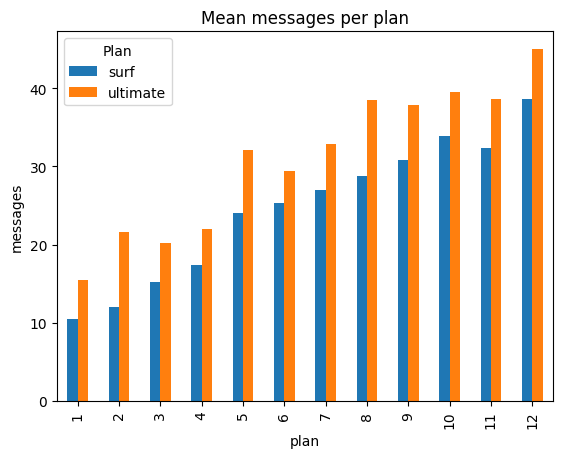

In [ ]:
# months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

mean_messages_per_plan = df_user_consumption.groupby(['month','plan_name'])['messages'].mean().reset_index()
mean_messages_per_plan = mean_messages_per_plan.pivot_table(index='month', columns='plan_name', values='messages')
print(mean_messages_per_plan)

mean_messages_per_plan.plot(
    kind='bar',
    title='Mean messages per plan',
    xlabel='plan',
    ylabel='messages',
)
plt.legend(title='Plan')
# plt.xticks(range(len(months)), months)



Podemos ver que la distribución con respecto a los mensajes mensuales, es bastante similar. El número de mensajes va incrementando mes con mes en ambos planes.

Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

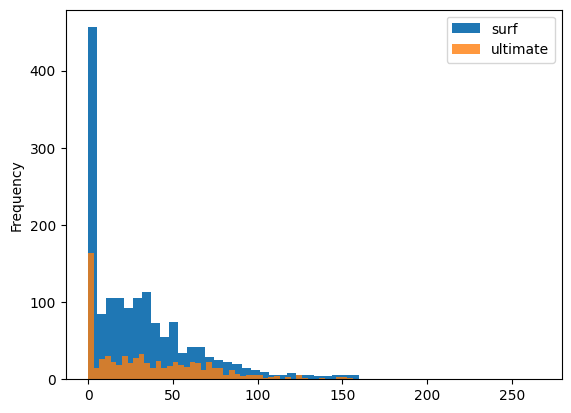

In [ ]:
sum_messages_per_user_id = df_user_consumption.groupby(['user_id','month','plan_name'])['messages'].sum().reset_index()

messages_surf = sum_messages_per_user_id[sum_messages_per_user_id['plan_name']=='surf']['messages']
messages_ultimate = sum_messages_per_user_id[sum_messages_per_user_id['plan_name']=='ultimate']['messages']

messages_surf.plot(kind='hist',bins=50)
messages_ultimate.plot(kind='hist',bins=50, alpha=0.8)
plt.legend(['surf', 'ultimate']) 

Una cantidad importante de usuarios no envía mensajes y la distribución de la frecuencia se encuentra en el rango de 0 a 50 mensajes mensuales en su mayoría.

count    1573.000000
mean       31.159568
std        33.566717
min         0.000000
25%         3.000000
50%        24.000000
75%        47.000000
max       266.000000
Name: messages, dtype: float64


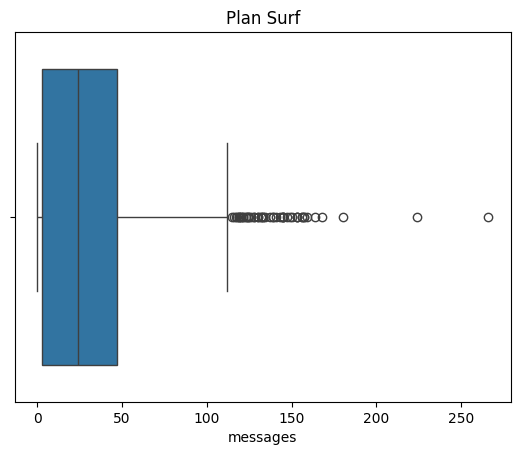

count    720.000000
mean      37.551389
std       34.767179
min        0.000000
25%        7.000000
50%       30.000000
75%       61.000000
max      166.000000
Name: messages, dtype: float64


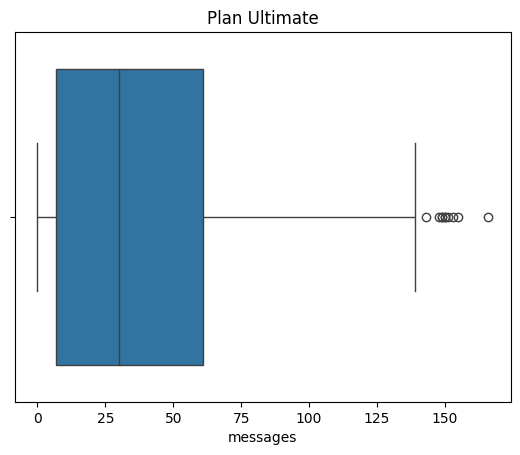

In [72]:
# Diagrama de caja para visualizar la distribución de la duración mensual de llamadas

print(messages_surf.describe())
surf_plt= sns.boxplot(x=messages_surf)
surf_plt.set_title('Plan Surf')
plt.show()

print(messages_ultimate.describe())
ultimate_plt=sns.boxplot(x=messages_ultimate)
ultimate_plt.set_title('Plan Ultimate')
plt.show()

Por los gráficos anteriores sabemos que existen algunos valores atípicos que se desvían del patrón general de los datos.  
También podemos ver que para el primer gráfico, que hace referencia al plan Surf, los datos son relativamente simétricos, mientras que para el plan Ultimate, están ligeramente sesgados a la derecha.  
Para el plan Surf, el 75% de los datos están por debajo de 47 mensajes y el IQR es de 44 mensajes.  
Para el plan Ultimate, el 75% de los datos están por debajo de 61 mensajes y el IQR es de 54 mensajes.  
De lo anterior, se puede decir que los usuarios del plan Ultimate suelen mandar más mensajes de texto al mes.

### Internet

plan_name       surf   ultimate
month                          
1           5.000000   7.250000
2          12.222222  17.285714
3          13.565217  18.416667
4          12.220000  16.333333
5          14.116883  16.862069
6          15.484536  15.425532
7          16.876033  16.491525
8          16.882716  17.845070
9          16.690722  17.011628
10         17.409283  17.716981
11         16.431095  17.118110
12         18.238994  18.397351


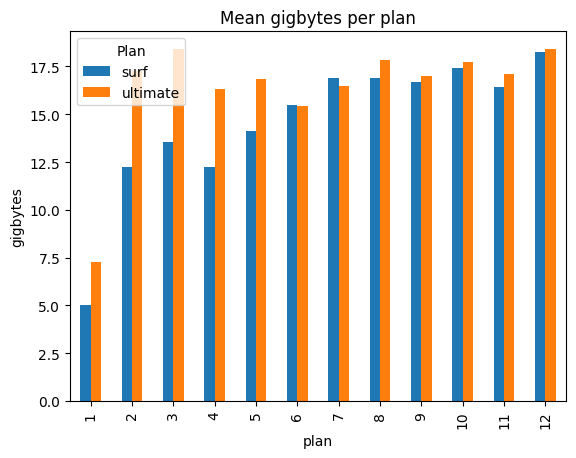

In [64]:
# Compara los gb promedio por cada plan y por cada mes.
mean_gb_per_plan = df_user_consumption.groupby(['month','plan_name'])['gb'].mean().reset_index()
mean_gb_per_plan = mean_gb_per_plan.pivot_table(index='month', columns='plan_name', values='gb')
print(mean_gb_per_plan)

mean_gb_per_plan.plot(
    kind='bar',
    title='Mean gigbytes per plan',
    xlabel='plan',
    ylabel='gigbytes',
)
plt.legend(title='Plan')

# months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# plt.xticks(range(len(months)), months)

Aquí podemos ver una diferencia notable, en los primeros meses del año los usuarios del plan Ultimate usaron más gigabytes que el resto del año.

Compraremos el número de gigabytes mensuales que tienden a usar los usuarios de los planes.

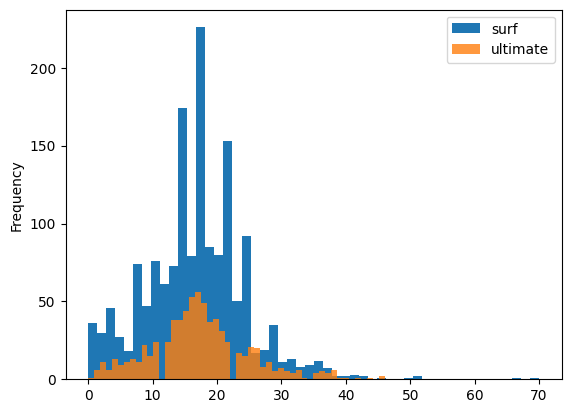

In [65]:
sum_gb_per_user_id = df_user_consumption.groupby(['user_id','month','plan_name'])['gb'].sum().reset_index()

gb_surf = sum_gb_per_user_id[sum_gb_per_user_id['plan_name']=='surf']['gb']
gb_ultimate = sum_gb_per_user_id[sum_gb_per_user_id['plan_name']=='ultimate']['gb']

gb_surf.plot(kind='hist',bins=50)
gb_ultimate.plot(kind='hist',bins=50, alpha=0.8)

plt.legend(['surf', 'ultimate'])

Los datos siguen una distribución similar. Por lo general, los usuarios consumen entre 10 y 20.5 gb mensualmente, en ambos planes.

count    1573.000000
mean       16.670693
std         7.847522
min         0.000000
25%        12.000000
50%        17.000000
75%        21.000000
max        70.000000
Name: gb, dtype: float64


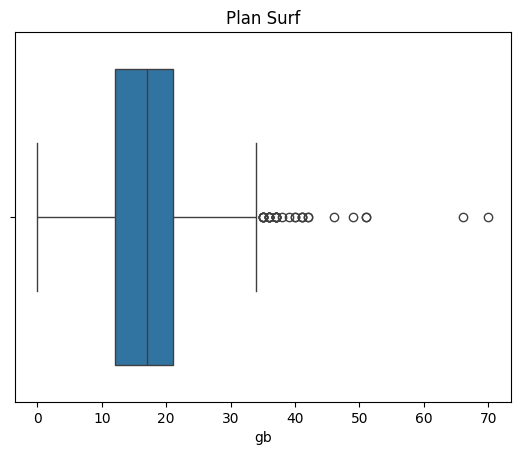

count    720.000000
mean      17.306944
std        7.670108
min        0.000000
25%       13.000000
50%       17.000000
75%       21.000000
max       46.000000
Name: gb, dtype: float64


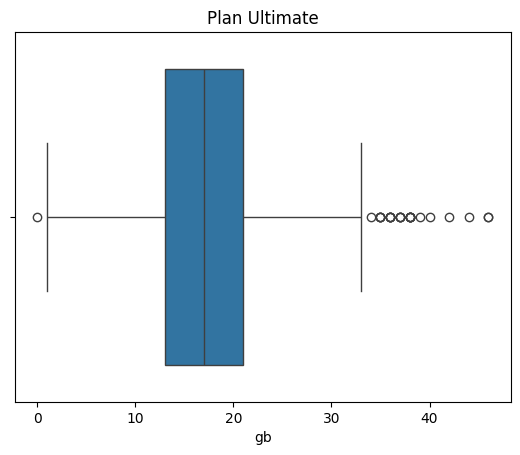

In [71]:
# Diagrama de caja para visualizar la distribución del consumo mensual de gigabytes
print(gb_surf.describe())
surf_plt= sns.boxplot(x=gb_surf)
surf_plt.set_title('Plan Surf')
plt.show()

print(gb_ultimate.describe())
ultimate_plt=sns.boxplot(x=gb_ultimate)
ultimate_plt.set_title('Plan Ultimate')
plt.show()

Para el plan Surf, el 75% de los meses tiene un consumo de 21 gb, con un rango intercuartil (IQR) de 9 gb. En contraste, para el plan Ultimate, el 75% del consumo mensual no supera los 21 gb, con un IQR de alrededor de 8 gb.  
En resumen, ambos planes parecen tener un consumo promedio similar, pero el plan Ultimate muestra una menor dispersión en los datos.

## Ingreso

Obtendremos el ingreso promedio de los usuarios de forma mensual para cada plan.

plan_name       surf   ultimate
month                          
1          20.000000  70.000000
2          33.333333  70.000000
3          45.756087  74.666667
4          39.985000  73.000000
5          46.820519  70.724138
6          48.574536  71.638298
7          61.656033  71.898305
8          63.061481  72.859155
9          57.400515  72.034884
10         64.614388  72.311321
11         57.031237  71.708661
12         69.447138  73.291391


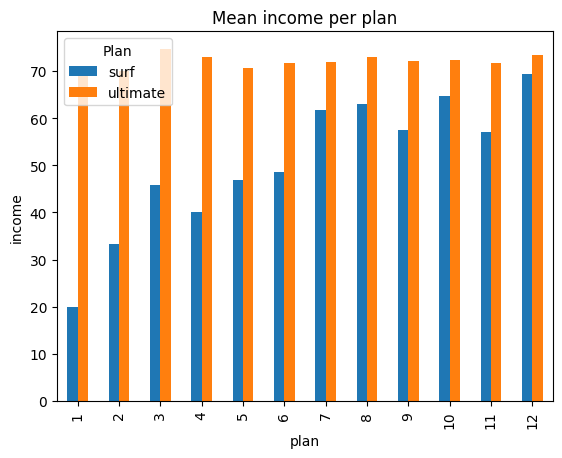

In [67]:
mean_income_per_plan = df_user_consumption.groupby(['month','plan_name'])['monthly_rate'].mean().reset_index()
mean_income_per_plan = mean_income_per_plan.pivot_table(index='month', columns='plan_name', values='monthly_rate')
print(mean_income_per_plan)

mean_income_per_plan.plot(
    kind='bar',
    title='Mean income per plan',
    xlabel='plan',
    ylabel='income',
)
plt.legend(title='Plan')

# months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# plt.xticks(range(len(months)), months)




El promedio del ingreso mensual es mayor y más constante por parte de los usuarios con plan Ultimate, a comparación de los usuarios con plan Surf.

Compraremps el ingreso mensual de los usuarios de cada plan.

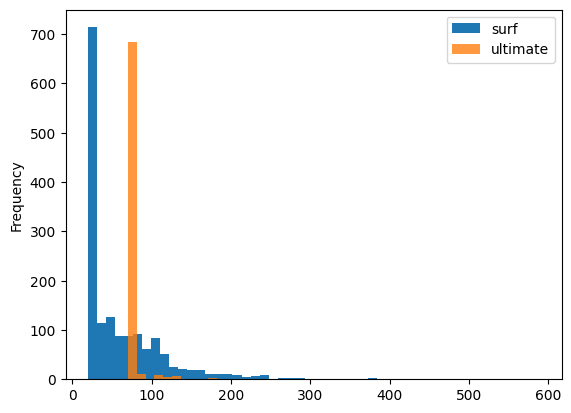

In [68]:
sum_rate_per_user_id = df_user_consumption.groupby(['user_id','month','plan_name'])['monthly_rate'].sum().reset_index()

rate_surf = sum_rate_per_user_id[sum_rate_per_user_id['plan_name']=='surf']['monthly_rate']
rate_ultimate = sum_rate_per_user_id[sum_rate_per_user_id['plan_name']=='ultimate']['monthly_rate']

rate_surf.plot(kind='hist',bins=50)
rate_ultimate.plot(kind='hist',bins=10, alpha=0.8)
plt.legend(['surf', 'ultimate'])

Los usuarios del plan Ultimate rara vez exceden los límites de su paquete, a diferencia de los usuarios del plan Surf, que lo hacen con mayor frecuencia

count    1573.000000
mean       59.795442
std        55.434944
min        20.000000
25%        20.000000
50%        40.000000
75%        80.000000
max       588.660000
Name: monthly_rate, dtype: float64


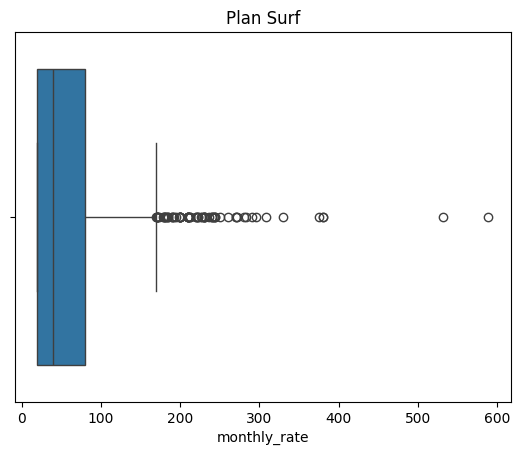

count    720.000000
mean      72.313889
std       11.395108
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      182.000000
Name: monthly_rate, dtype: float64


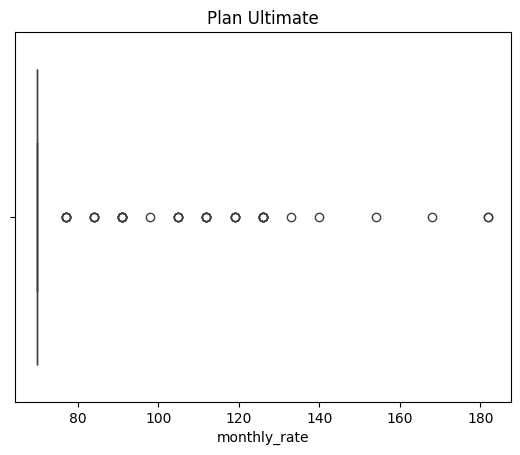

In [70]:
# Diagrama de caja para visualizar la distribución de los ingresos de cada plan
print(rate_surf.describe())
surf_plt= sns.boxplot(x=rate_surf)
surf_plt.set_title('Plan Surf')
plt.show()

print(rate_ultimate.describe())
ultimate_plt=sns.boxplot(x=rate_ultimate)
ultimate_plt.set_title('Plan Ultimate')
plt.show()

Hay que hacer enfasis en que, para el plan Ultimate, los cuartiles Q1, Q2 y Q3 son iguales, es decir, los valores están igualmente distribuidos alrededor de la mediana. El IQR es igual a 0 y el 50% medio de los datos son iguales a 70. Ademas, el 75% de los datos, son menores a 70 y el resto son valores atípicos.  
En contraste, para el plan Surf, el 75% de los datos está por debajo de 80, y el IQR es de 60.  
Por lo tanto podemos concluir que, los usuarios del plan Surf tienden a tener un consumo ligeramente mayor que los usuarios del plan Ultimate. Sin embargo, el plan Ultimate muestra una distribución más uniforme de los datos alrededor de la mediana, mientras que el plan Surf tiene una mayor variabilidad.

## Prueba las hipótesis estadísticas

Queremos comprobar si son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.  
Como la función ttest_ind, solo comprueba igualdades, partimos de la siguiente hipotesis nula:  
"La media de los ingresos procedentes de los usarios con planes Ultimate, es igual a la media de los ingresos procedentes de los usarios con planes Surf".  
Por lo que la hipotesis alternativa sería:  
"La media de los ingresos procedentes de los usarios con planes Ultimate, no es igual a la media de los ingresos procedentes de los usarios con planes Surf".

In [ ]:
# Extraemos una muestra de 50 elementos de los ingresos mensuales para cada usuario por plan
sample_1 = rate_surf.sample(n=50)
sample_2 = rate_ultimate.sample(n=50)

# Comprobamos si las varianzas son aproximadamente iguales
print('varianza 1:', sample_1.var())
print('varianza 2:', sample_2.var())

varianza 1: 3772.334671877551
varianza 2: 66.5


In [ ]:

alpha = 0.05  # establecemos el nivel de significancia estadística crítica en 5%

results = st.ttest_ind(sample_1, sample_2, equal_var = False) # las varianzas son diferentes, entonces configuramos equal_var = False

print('valor p: ', results.pvalue) # extraemos el valor p

if results.pvalue < alpha: # comparamos el valor p con el nivel de significancia
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


valor p:  0.8404203201891958
No podemos rechazar la hipótesis nula


Debido a que el valor p, que indica la probabilidad de que las medias sean iguales, es bastante alta, no podemos rechazar la hipotesis núla. De esta forma, podemos decir que es probable que las medias de ambas probabilidades sean iguales o por lo menos muy similares, por lo tanto, no se puede confirmar que sean diferentes los ingresos promedio de ambos planes.  



Queremos comprobar que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.  
Para esto, estableceremos la siguiente hipótesis nula:  
"La media de los ingresos procedentes de los usarios del área NY-NJ , es igual a la media de los ingresos procedentes de los usarios de otras regiones".  
La hipotesis alternativa sería la siguiente:  
"La media de los ingresos procedentes de los usarios del área NY-NJ , no es igual a la media de los ingresos procedentes de los usarios de otras regiones".  

In [76]:
# Agregamos la columna 'city' al dataframe del consumo del usuario
df_city = df_user_consumption.merge(
    df_users[['user_id','city']],
    on='user_id',
    how='right',
)
print(df_city.head(5))

   user_id plan_name  month  calls  minutes  messages    gb  \
0     1000  ultimate   12.0   16.0    117.0      11.0   2.0   
1     1001      surf    8.0   22.0    172.0      30.0   7.0   
2     1001      surf    9.0   38.0    298.0      44.0  14.0   
3     1001      surf   10.0   47.0    375.0      53.0  22.0   
4     1001      surf   11.0   49.0    405.0      36.0  19.0   

   messages_included  gb_per_month_included  minutes_included  \
0             1000.0                   30.0            3000.0   
1               50.0                   15.0             500.0   
2               50.0                   15.0             500.0   
3               50.0                   15.0             500.0   
4               50.0                   15.0             500.0   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute  monthly_rate  \
0             70.0         7.0             0.01            0.01         70.00   
1             20.0        10.0             0.03            0.03     

In [77]:
# Extraemos los usarios del área NY-NJ y de el resto de regiones
df_NY_NJ = df_city[df_city['city']=='New York-Newark-Jersey City, NY-NJ-PA MSA']
df_other_areas = df_city[df_city['city']!='New York-Newark-Jersey City, NY-NJ-PA MSA']

# Obtenemos una agrupación por usuario y mes
group_df_NY_NJ = df_NY_NJ.groupby(['user_id','month'])['monthly_rate'].sum().reset_index()
group_df_other_areas = df_other_areas.groupby(['user_id','month'])['monthly_rate'].sum().reset_index()
# Obtenemos muestras de 50 elementos
sample_NY_NJ = group_df_NY_NJ['monthly_rate'].sample(n=50)
sample_other_areas = group_df_other_areas['monthly_rate'].sample(n=50)

# comprobamos si las varianzas son aproximadamente iguales
print('varianza 1:', sample_NY_NJ.var())
print('varianza 2:', sample_2.var())

varianza 1: 1439.6943046530612
varianza 2: 66.5


In [78]:
# Prueba las hipótesis
alpha = 0.05  # establecemos el nivel de significancia estadística crítica en 5%

results_2 = st.ttest_ind(sample_NY_NJ, sample_other_areas, equal_var = False) # las varianzas son diferentes, entonces ponemos equal_var = false

print('valor p: ', results_2.pvalue) # extraer el valor p

if results_2.pvalue < alpha: # comparar el valor p con el nivel de significancia
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

valor p:  0.42582926334071824
No podemos rechazar la hipótesis nula


Parece que la probabilidad de que el ingreso promedio, proveniente de los usuarios del área NY-NJ, sea igual al de otras regiones, es más alta que el 5%, por lo que no podemos rechazar la hipótesis nula y no podemos decir que hay una diferencia significativa de ingresos, con respecto al resto de las regiones

## Conclusión general

La comprobación de una hipótesis nos permite determinar si una condición se cumple. Además, es crucial preparar los datos adecuadamente para realizar un procesamiento preciso y evitar obtener resultados erróneos o engañosos que podrían ser contraproducentes.  
Según los resultados obtenidos durante el proyecto, existe una alta probabilidad de que el plan Ultimate sea más rentable para la empresa. A pesar de tener menos usuarios suscritos a este plan y de que los usuarios no superen con tanta frecuencia los límites del mismo, los ingresos son constantes y altos debido al costo del plan.